In [17]:
import pandas as pd, json
import numpy as np
import matplotlib.pyplot as plt
from ipdb import set_trace

### Data processing functions

In [20]:
reno_num = range(1, 34, 4)
bbr_num = range(1, 34, 4)
queues = [0.25, 0.5, 1, 4, 8, 16, 32]
times = [60, 60, 60, 60, 60, 100, 200]

tcp_size = 60 * 8 # bits
bw = 10000000 / tcp_size # packets per second
rtt = 0.04 # seconds

def get_bps(bdp, bbr_num, loss_num, bbr=True):
    f = open(f"./iperf3_results/all_{bdp}/{'bbr' if bbr else 'cubic'}_{bdp}_{bbr_num}_{loss_num}_10_40.json")
    data = json.load(f)
    if not 'sum_sent' in data['end']: # guard for bad data (timed out too soon in data_collector)
        return -1
    bps = data['end']['sum_sent']['bits_per_second']
    
    return bps

'''
    c: packets per milisecond
    l: miliseconds
    X: # of BDP 
    N: # of BBR
    d: duration after convergence
'''
def get_model_rates(N, c, l, X, d):
    
    q = X * c * l/2
    p = 0.5 - 1.0/(2*X) - 4.0*N/q
    p_t = (q/c + 0.2*l) * d/10
    bbr_frac = (1-p) * (d-p_t) / d
#     set_trace()
    return min(1, bbr_frac)

def get_rates(bbr_num, loss_num, duration=1, isModel=False):
    rates = []
    for q in queues:
        if isModel:
            frac = get_model_rates(bbr_num, bw, rtt, q, duration)
            rates.append(frac)
        else:
            b_rate, l_rate = get_bps(q, bbr_num, 1, True), get_bps(q, bbr_num, 1, False)
            rates.append(b_rate / (b_rate + l_rate))

    return rates


### Plot curves

/tmp/ipykernel_5983/412921310.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([0] + queues)


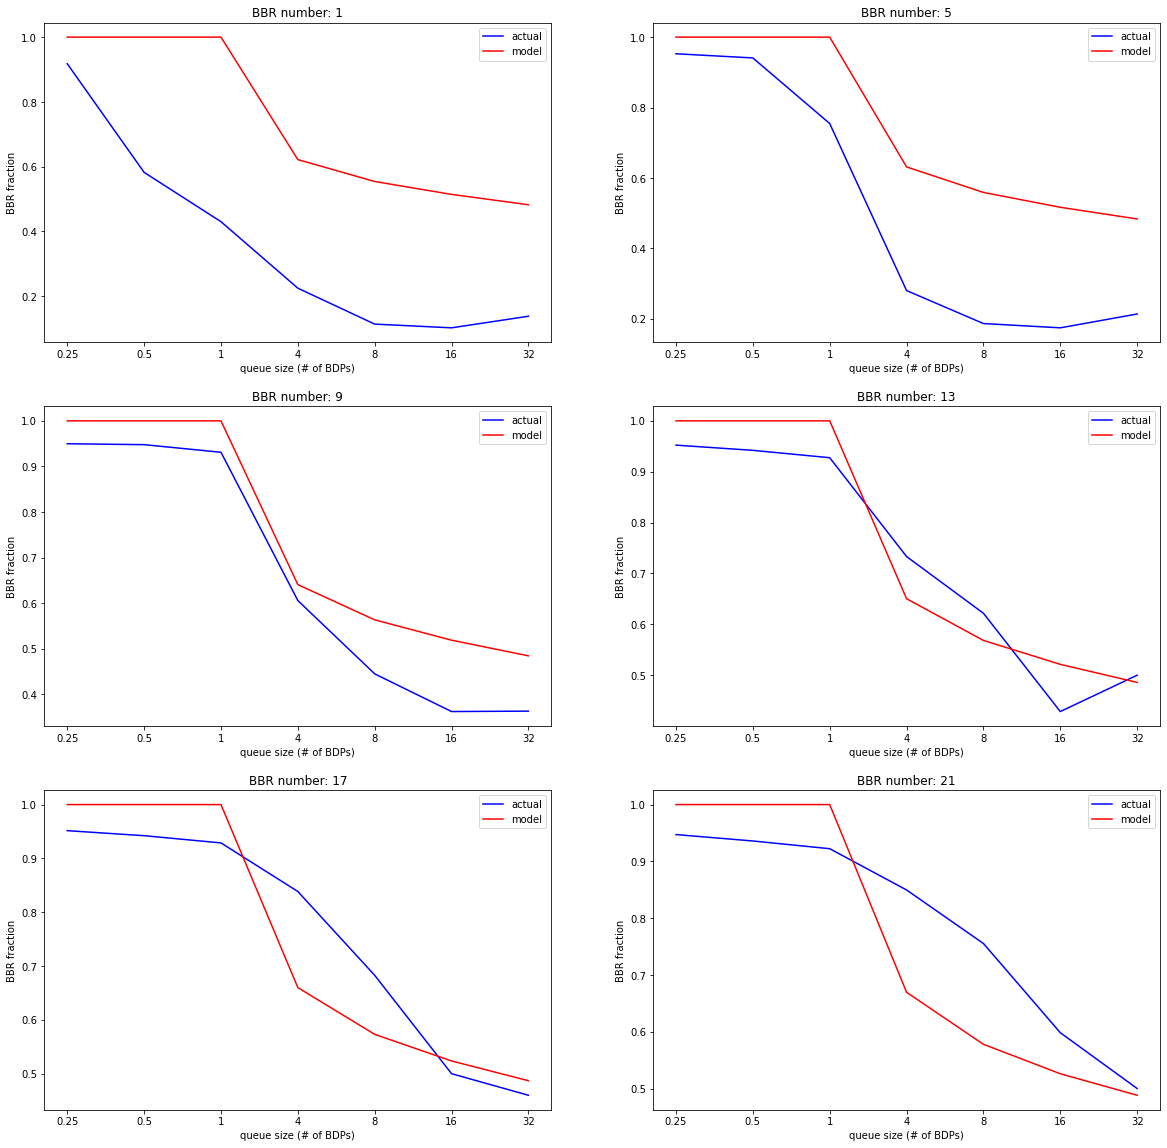

In [30]:
fig = plt.figure(1, figsize=(20, 20))
i = 1
for n in bbr_num[:6]:
    
    real_rates = get_rates(n, 1)
    model_rates = get_rates(n, 1, duration=1, isModel=True)
    ax = fig.add_subplot(int(f'32{i}'))
    i += 1
    ax.set_title(f'BBR number: {n}')
    ax.xaxis.set_ticklabels([0] + queues)
    ax.set_xlabel('queue size (# of BDPs)')
    ax.set_ylabel('BBR fraction')
    ax.plot(real_rates, color='b', label='actual')
    ax.plot(model_rates, color='r', label='model')
    ax.legend()

plt.show()

In [12]:
%debug

> /tmp/ipykernel_5983/2322167408.py(13)get_bps()
     11     f = open(f"./iperf3_results/all_{bdp}/{'bbr' if bbr else 'cubic'}_{bdp}_{bbr_num}_{loss_num}_10_40.json")
     12     data = json.load(f)
---> 13     bps = data['end']['sum_sent']['bits_per_second']
     14 
     15     return bps

ipdb> f"./iperf3_results/all_{bdp}/{'bbr' if bbr else 'cubic'}_{bdp}_{bbr_num}_{loss_num}_10_40.json"
'./iperf3_results/all_32/bbr_32_13_1_10_40.json'
ipdb> exit


In [23]:
print(len(bbr_num))

9
